In [38]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
from src.data import *

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

### Business Understanding

Clean water is crucial to the Tanzanian people. Rain comes only seasonally, with long wet and dry seasons, and many water sources are seasonal as well. Unclean water is responsible for many deaths from typhoid and other diseases.

4 million people in Tanzania lack access to an improved source of safe water, and 30 million don't have access to improved sanitation. People living under these circumstances, >particularly women and girls, spend a significant amount of time traveling long distances to collect water. 1

We are using the Pump it Up: Data Mining the Water Table2 dataset from the Driven Data competition. This dataset has information about wells in Tanzania recorded between 2002 and 2013. This features of this dataset include information about when, how, and who constructed the wells, where they are located, what methods they use to extract and distribute water, water quality and quanitity, as well as how the wells are managed and how the people pay for the water they take.

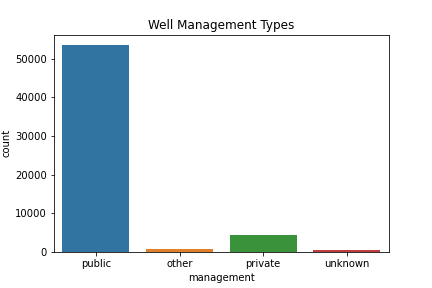

A large number of organizations have funded and installed wells in the country, but most are managed locally by village water associations and trusts. Some are managed by companies or private individuals.

The wells have also not been uniformly distributed, as you can see on the map below. It seems certain regions have attracted more projects than others.

The good news is that most wells in Tanzania were functioning in 2013, and innovations such as solar powered wells have reduced the cost of operation and maintenance of many wells. However, disrepair is still an issue in many places and well maintenance can save many lives from starvation, thirst, and water-borne disease.

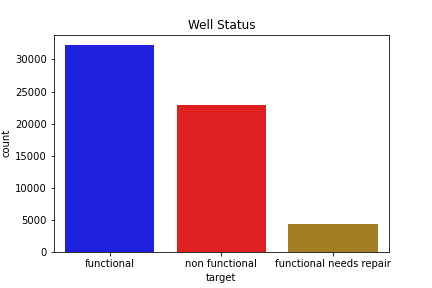

### Data Understanding

The dataset we used contains volumnious and often redundant information about each well. Many features were mostly redundant, such as `water_quality` and `water_quality_group` or `scheme_management` and `management`. Others had too many categorical values to encode, or were so specific to each well as to be of little use in making predictions such as `scheme_name` or `installer`. 

**Features:**
1. `amount_tsh`: total static head.  How high the water gets pumped from where it starts.
2. `date_recorded`: when this row was updated/created
3. `funder`: who funded the well
4. `gps_height`: altitude of well
5. `installer`: who installed the well
6. `latitude`/`longitude`: location of well
7. `wpt_name`: name of the waterpoint (well)
8. `basin`: geographic water basin
9. `subvillage`: village or street, see Regional subdivisions in Tanzania below
10. `region`: see Regional subdivisions in Tanzania below
11. `region code`: 
12. `district code`:
13. `lga`: district, see Regional subdivisions in Tanzania below
14. `ward`: see Regional subdivisions in Tanzania below
15. `population`: population around well (subvillage?)
16. `public meeting`: ? (true/false/NaN)
17. `recorded_by`: group entering data for this row
18. `scheme_management`: type of management.  (see Water Managemtn Types below)
19. `scheme_name`: name of well management group
20. `permit`: is permitted by local water basin authority
21. `construction_year`: year constructed
22. `extraction_type`: specific extraction method
23. `extraction_type_group`: less specific than extraction_type
24. `extraction_type_class`: broadest class of extraction type
25. `management`: how well is managed: see Water Management Types below
26. `management_group`: broader type of management: see Water Management Types below
27. `payment`/`payment_type`: how the water is paid for.
28. `water_quality`: description of water from well
29. `quality_group`: less specific quality type.
30. `quantity`/`quanitity_group`: how much water or when there is water
31. `source`/`source_type`/`source_class`: where the water from the well comes from 
32. `waterpoint_type`/`waterpoint_type_group`: type of extraction point, what users interact with to get water.


When working through these features we can highlight several redundent features. For example the columns: basin, subvillage, region, region code, district code, lga, ward all refer to geographic regions getting progresively more focused on the well loction.

Going through these redundencies we can narrow down the features we want to add to our model. Bellow are a list of redundencies we found:
1. `basin`, `subvillage`, `region`, `region code`, `district code`, `lga`, `ward`:
2. `water_quality`, and `quality_group`
3. `quantity`, `quantity group`
4. `source`, `source_type`, `source_class`
5. `waterpoint_type`, `waterpoint_type_group`
6. `payment`, `payment_type`
7. `management`, `management_group`, `scheme_management`
8. `extraction_type`, `extraction_type_class`, `extraction_type_group`

### Preproccesing Data

Before we could start working with the data we need to prepare it for modeling. We went through several steps to prepare our data.

1. We dropped very specific features and kept only one of each of the redundant features identified above.

2. We scaled the numeric data so each features' values were comparable to each other. This helps prediction models to compare features evenly without losing information.

3. date_recorded was originally full of strings of dates, but we transformed them into numbers with the whole number as the year and the decimal representing the months (1/month).

4. We imputed missing values in permits column, filling missing values with the most common value. Then we replaced the '0' entries for construction_date with the median date.

5. With date_recorded as a number and all values of construction_year we were able to add a feature describing the age of the pump. We predicted this would be very important in predicting its need for maintenance.

6. We one-hot-encoded categorical features, creating a binary column for each category within them. Algorithmic models can only understand numbers.

**data.py**

We built several methods that allow us to more efficently process the data. The first of these is "load_data()" it takes the value of X, y and: 
1. Load data into DataFrame, 
2. Set index to `id`
3. Drop categorical columns with too many values to one-hot
4. Set y to numeric classes
5. Returns X (features) and y (labels)

We also created a WellProcessor class that takes data from the Tanzanian well dataset and processes it for modeling.  This includes: 
1. Imputing missing data for `permit` and `construction_date`
   as well as transforming `date_recorded` into a float.
2. Scaling numeric data
3. One-hot-encoding categorical data
    
The class also contain several methods:
1. fit(X): Fit all transformers on a dataset.  Returns None.
2. transform(X): Use fitted transformers to transform data.  Returns a dataframe.
3. fit_transform(X): Fit and transform data using transformers.  Returns a dataframe.

In [18]:
X, y = load_data()

Now that our data is loaded we are ready to split the data into a train set and a test set at an 80/20 split respectively

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Models

**Preproccesing data for XGBoost and LightGBM**

Since XGBoost is not compatible with SKlearn it does not work with the run_model function we built, becuase of this we need to transform and prepare the data seperately from any SKLearn based models. We used the previously mention WellProcessor() class.

In [20]:
#Initiate the WellProcessor class
wp = WellProcessor()

#Fit the WellProcessor
wp.fit(X_train)
X_train = wp.transform(X_train)

#Transform our test data
X_test = wp.transform(X_test)

$XGBoost$

XGBoost is one of the strongest, if not the strongest, model on the market currently. We wanted to start with a strong model to see what kind of results it can give as a benchmark.

In [39]:
# Instantiate XGBClassifier
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train, y_train)

# Predict on training and test sets
training_preds_xgb = XGB.predict(X_train)
test_preds_xgb = XGB.predict(X_test)

# Printing the Classification Report to see how our model performed
print(classification_report(y_test, test_preds_xgb))

While XGBoost gave great results with default hyperparameters, it took a minimum of 12minutes to run. We wanted to compare its results to more efficient models.

*$DecisionTreeClassifier$*

Our next model was a Decision Tree. We wanted something to compare to XGBoost that was a little bit more simple but still could deal with complex models. We also wanted a model that could execute faster than XGBoost.

In [4]:
rn_dtc = run_model (X_train, y_train, DecisionTreeClassifier())

0.7634231192054719


In [5]:
rn_dtc.best_score_

0.7634231192054719

We had a nice score from our Decision Tree Classifier, but not as high as our XGBoost.

$Random Forest Classifier$

While our Decision Tree Classifier gave good results we wanted to try a more complex Random Forest Classifier to compare it to. We had great success with Random Forest in previous work, so it seemed like a natural choice.

In [10]:
rn_rfc = run_model (X_train, y_train, RandomForestClassifier())

0.7850647936575831


In [11]:
rn_rfc.best_score_

0.7850647936575831

The Random Forest gave a better score than my Decision Tree, which was great but the improvement wasnt as large as we were hoping. It was also slower than the Decision Tree.

$LightGBM$

After a misreble attempt with a Naive Bayes model we did some research into fast models that can deal with large datasets. LightGBM is reported to be as competitive as XGBoost but with much faster times.

In [21]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_train, y_train)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_train)
test_preds_lgbm = lgbm.predict(X_test)

# Printing the Classification Report to see how our model performed
print(classification_report(y_test, test_preds_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      4572
           1       0.65      0.23      0.34       851
           2       0.76      0.91      0.83      6457

    accuracy                           0.79     11880
   macro avg       0.75      0.62      0.65     11880
weighted avg       0.79      0.79      0.77     11880



We found this model fast, but with a lower score than our Random Forest model.

### Hypertuning

Now that we have wroekd our way through several models, we established that RandomForestClassifier is the strongest performing model. We then starterd Hypertuning our parameter with a parameter grid using our run_model function. We picked several parameters, and gave them ranges as a starting point. We chose the parameters that would help with overfitting and raising our score.

In [52]:
param_grid = {
    'estimator__max_depth': [5,6,7,8],
    'estimator__min_samples_split': [500,1000,1500],
    'estimator__max_leaf_nodes': [10,25,50],
    'estimator__min_samples_leaf': [100, 250]
}

In [53]:
rn_rfc_bp = run_model (X_train, y_train, RandomForestClassifier(), param_grid=param_grid)
# Show the best paramters from our grid
rn_rfc_bp.best_params_

0.5196142021514092


The above method didn't work as well as we were hoping, and reduced our model's score dramaticlly. As all the estimators are at the extremes of each range, we chose to go with another approach and use Validation Curves. Building the curve and plotting it will help show me the direction and slope of the score. Graphing the Validation curve also helped us prevent using a parameter that will cause overfitting.

**n_estimators**

We then highlighted n_estimators as a parameter that we need to explore futher as it helps fix overfitting.

In [54]:
#Setting the range of our Hyperparameter
param_range = [300, 500, 750, 800, 1200]

#Validation Curve
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(max_depth=30, class_weight="balanced"),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

#Print the array of train and test to compare
print(train_scoreNum)
print(test_scoreNum)

[[0.98772096 0.9885101  0.98879419]
 [0.98844697 0.98920455 0.98980429]
 [0.98857323 0.98936237 0.99005682]
 [0.98825758 0.98907828 0.98986742]
 [0.9884154  0.98907828 0.99015152]]
[[0.79204545 0.79823232 0.79532828]
 [0.79311869 0.79835859 0.79640152]
 [0.79229798 0.79709596 0.79526515]
 [0.79191919 0.79760101 0.79627525]
 [0.79248737 0.79760101 0.79614899]]


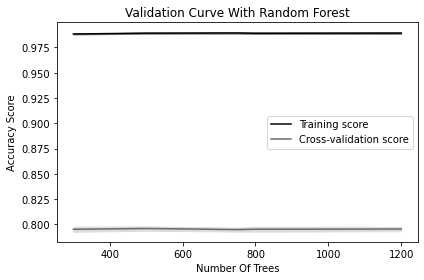

In [55]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

**max_depth**

Max depth was another parameter we dug into with a validation curve as it has a strong impact on overfitting.

In [155]:
#Setting the range of our Hyperparameter
param_range=[15,20,25,30,35,40]

#Validation Curve
train_scoreMD, test_scoreMD = validation_curve(
                                RandomForestClassifier(class_weight='balanced_subsample'),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = param_range, cv = 3)

#Print the array of train and test to compare
print(train_scoreMD)
print(test_scoreMD)

[[0.80334596 0.79955808 0.7967803 ]
 [0.89756944 0.89662247 0.89659091]
 [0.95969066 0.96089015 0.96076389]
 [0.98784722 0.98683712 0.98734217]
 [0.99520202 0.99472854 0.99548611]
 [0.99703283 0.9969697  0.99709596]]
[[0.73667929 0.74166667 0.72853535]
 [0.77417929 0.7792298  0.77032828]
 [0.78731061 0.79602273 0.78977273]
 [0.79236111 0.79539141 0.79513889]
 [0.79349747 0.79602273 0.79526515]
 [0.79349747 0.79690657 0.79513889]]


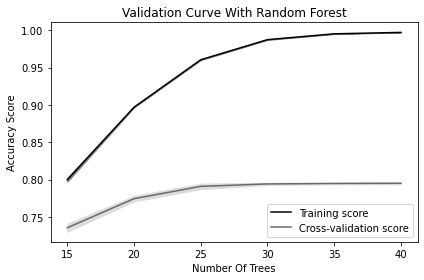

In [156]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreMD, axis=1)
train_std = np.std(train_scoreMD, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreMD, axis=1)
test_std = np.std(test_scoreMD, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

We can see we get the strongest scores at n_estimators=500 and max_depth=25. Max depth seems to have a relationship with overfitting, so we used this feature to help prevent to much overfitting of our train data.

In [ ]:
y_train.value_counts()

We see that our y value counts are not balanced so we added a class_weight to help compensate.

In [ ]:
rn_bm = run_model (X_train, y_train, RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample'))

### Best Model

Our best model is a RandomForest Classifier with n_estimators=500, max_depth=25 and class_weight balanced_subsample.

Our focus was producing the highest Recall on The model returned a Recall Score on Class 0 ('Non-Functioning') of .79 on the test set, and a 1.0 on the training set. Recall on Class 0 measures what percentage of the truly non-functioning wells our model correctly identifies. Our model correctly predicts truly non-functioning wells 79% of the time on our test data.
Given the very high scores across our training data, we are aware that we may have some overfitting, that needs to be addressed.

The model performs well at predicting both the Class 2 (Functional) and Class 0 (Non-Functional) classes, however, it struggles with the Class 1 (Functional but Needs Repair) class, which is the smallest class and is underrepresented in the training data.


In [31]:
best_model = run_model (X_train, y_train, RandomForestClassifier(max_depth=25, n_estimators=500, class_weight='balanced_subsample'))

0.7653404621739963


In [32]:
# Creating the y_predictor variables
y_pred_best = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Printing a classifcation report for our best model
print(classification_report(y_train, y_pred_best))
print(classification_report(y_test, y_pred_test))

# Saving y preds train
y_pred_tr = pd.DataFrame(data=y_pred_best, columns=y_train.columns, index=y_train.index)
y_pred_tr.to_csv('../data/best_y_preds.csv')

# Saving y preds test
y_pred_test_best = pd.DataFrame(data=y_pred_test, columns=y_test.columns, index=y_test.index)
y_pred_test_best.to_csv('../data/y_preds_test.csv')

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     18252
           1       0.79      0.96      0.87      3466
           2       0.95      0.97      0.96     25802

    accuracy                           0.95     47520
   macro avg       0.91      0.95      0.93     47520
weighted avg       0.95      0.95      0.95     47520

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4572
           1       0.41      0.50      0.45       851
           2       0.82      0.85      0.84      6457

    accuracy                           0.80     11880
   macro avg       0.69      0.71      0.70     11880
weighted avg       0.80      0.80      0.80     11880



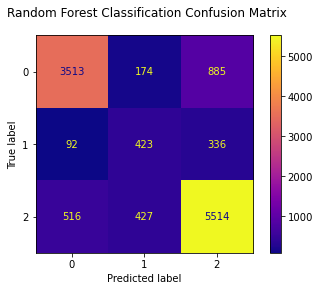

In [35]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classification Confusion Matrix")

plot_confusion_matrix(best_model, X_test, y_test, ax=ax, cmap="plasma");

### Going Forward

Given more time for this project, we suggest improving the model and investigating well functionality further in the following ways:

1. Address class imbalances to better identify wells that need repair but are still functioning.
2. Delve deeper into our training model with regards to potential overfitting.
3. Investigate the regions in our map in which our accuracy is low, and understand what is causing these drops.